# <br> DBSCAN Clustering analysis performed for hotels' data coming from Bidroom DB: min_samples adjusted to dimentions <br>

### Information about data set:<br>
#### 1. Analysis was performed for sample about 1000 data from database. 
#### 2. Data were taken for two cities with the higest number of active hotels. <br> 


In [374]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

## Importing Libraries

In [375]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set()
### libraries to reduce data
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
##libraries needed for clustering analysis
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import euclidean
from DBCV.DBCV import DBCV

pd.set_option('display.max_columns', 100)
pd.set_option('display.expand_frame_repr', True)


## Importing file with data and creating its copy

#### <br> This set of characteristics was discussed and chosen as the most valuable/informative out of other available in database with Thomas <br>

In [376]:
file = pd.read_csv("Documents/clustering/dbscan/idGBdata.csv")
fileWorking = file.copy()
fileWorking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hotel_id             1040 non-null   int64  
 1   hotel_city           1040 non-null   int64  
 2   hotel_type           1040 non-null   int64  
 3   hotel_country        1040 non-null   object 
 4   hotel_currency_code  1040 non-null   object 
 5   hotel_lat            1040 non-null   float64
 6   hotel_lon            1040 non-null   float64
 7   hotel_distance       881 non-null    float64
 8   rooms_count          1040 non-null   int64  
 9   room_type_en         188 non-null    object 
 10  room_type_no         238 non-null    float64
 11  label                0 non-null      float64
 12  amenity              1038 non-null   object 
dtypes: float64(5), int64(4), object(4)
memory usage: 105.8+ KB


#### <br> This analysis is provided for characteristics without the room_types that is why I am removing from original file thwo columns: room_type_no and room_type_en  <br>

In [377]:
fileWorking = fileWorking.drop(columns=["room_type_no","room_type_en"])

### <br>**Expectations/hypothesis behind chosen characteristics:**<br>
#### - **hotel_currency_code** will probably be highly correlated with eg Country, here is just taken to confirm that and remove from future analysis;
#### - **hotel_distnace** should be very informative and diverging characteristics because it calculates the distance from the city center;
#### - **amenities list**  amenities are chosen because, in my and Thomas opinion, to compare prices we should compare them among not only hotels with the same type but also with the same offer according to what is available for the guest to make their stay more comfortable;
#### - **rooms_count** were chosen because we should compare prices among hotels which are more or less the same size, if a guest prefers small hotels he will be comparying prices among the small ones;
#### This analysis is a first of such type for the data we are storing in our database and I didn't wanted to miss any level that cound be crucial for hotels categorization<br>

## Data Preprocessing

In [378]:
fileWorking.head()

,hotel_id,hotel_city,hotel_type,hotel_country,hotel_currency_code,hotel_lat,hotel_lon,hotel_distance,rooms_count,label,amenity
0,5622,1174,4,GB,GBP,51.521259,-0.155856,3.12,34,NaN,"Free WIFI,Elevator / Lift,Air Conditioned,Free..."
1,5630,1174,3,GB,GBP,51.512071,-0.185206,4.30,45,NaN,"Free WIFI,Elevator / Lift,Free WIFI,Elevator /..."
2,5640,1174,4,GB,GBP,51.507706,-0.147138,1.67,106,NaN,"Free WIFI,Elevator / Lift,Parking,Fitness Room..."
3,5671,1174,4,GB,GBP,51.490098,-0.138130,1.39,72,NaN,"Free WIFI,Elevator / Lift,Air Conditioned,Free..."
4,5681,1174,5,GB,GBP,51.496872,-0.167604,2.89,28,NaN,"Free WIFI,Elevator / Lift,Parking,Pet Friendly..."


#### I used the one-hot-encoding for hotel_type - separate column was created for each hotel_type and as a value was 1 if the hotel was that type and 0 otherwise

In [379]:
def hotel_type_to_columns(df):
    hotel_type_dict = {
        1:"1-star_Hotel",
        2:"2-star_Hotel",
        3:"3-star_Hotel",
        4:"4-star_Hotel",
        5:"5-star_Hotel",
        8:"Apartment_Hotel_Type",
        9:"Hostel",
        10:"Motel",
        11:"Inn",
        12:"Bed&Breakfast",
        13:"Vacation_Rental",
        15:"Resort",
        16:"Other",
        23:"Aparthotel",
        25:"Boutique_Hotel",
        30:"Guesthouse",
        32:"Camping",
        33:"Villa",
        34:"Farm_Stay",
        36:"Hotel"
    }   
    df["hotel_type_en"] = df.hotel_type.map(hotel_type_dict)
    df = pd.get_dummies(df, prefix=["ht"], columns=['hotel_type_en'])
    
    df.columns = df.columns.str.lower()
    return df


In [380]:
fileWorking = hotel_type_to_columns(fileWorking)

In [381]:
fileWorking = fileWorking.drop(columns=["hotel_type"])

In [382]:
fileWorking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hotel_id                 1040 non-null   int64  
 1   hotel_city               1040 non-null   int64  
 2   hotel_country            1040 non-null   object 
 3   hotel_currency_code      1040 non-null   object 
 4   hotel_lat                1040 non-null   float64
 5   hotel_lon                1040 non-null   float64
 6   hotel_distance           881 non-null    float64
 7   rooms_count              1040 non-null   int64  
 8   label                    0 non-null      float64
 9   amenity                  1038 non-null   object 
 10  ht_1-star_hotel          1040 non-null   uint8  
 11  ht_2-star_hotel          1040 non-null   uint8  
 12  ht_3-star_hotel          1040 non-null   uint8  
 13  ht_4-star_hotel          1040 non-null   uint8  
 14  ht_5-star_hotel         

#### <br> Amenities column contains a list of amenities for specific hotel in one cell. That Is why I put them to separate coulmns and gave True (1) if the hotel has that and False (0) otherwise <br>

#### <br> First I removed two rows that didn't have any amenities and label column that did not have any data <br>

In [383]:
fileWorking.loc[pd.isna(fileWorking["amenity"]), :].index

Int64Index([109, 111], dtype='int64')

In [384]:
fileWorking = fileWorking.drop([fileWorking.index[109], fileWorking.index[111]])

In [385]:
fileWorking = fileWorking.drop(columns=["label"])

In [386]:
fileWorking.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1038 entries, 0 to 1039
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hotel_id                 1038 non-null   int64  
 1   hotel_city               1038 non-null   int64  
 2   hotel_country            1038 non-null   object 
 3   hotel_currency_code      1038 non-null   object 
 4   hotel_lat                1038 non-null   float64
 5   hotel_lon                1038 non-null   float64
 6   hotel_distance           879 non-null    float64
 7   rooms_count              1038 non-null   int64  
 8   amenity                  1038 non-null   object 
 9   ht_1-star_hotel          1038 non-null   uint8  
 10  ht_2-star_hotel          1038 non-null   uint8  
 11  ht_3-star_hotel          1038 non-null   uint8  
 12  ht_4-star_hotel          1038 non-null   uint8  
 13  ht_5-star_hotel          1038 non-null   uint8  
 14  ht_aparthotel           

### Creating separate sets of amenities for each city

#### Creating working file for Jakarta in Indonesia

In [387]:
fileWorkingID = fileWorking.loc[fileWorking.hotel_country=="ID"]
fileWorkingID.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648 entries, 17 to 995
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hotel_id                 648 non-null    int64  
 1   hotel_city               648 non-null    int64  
 2   hotel_country            648 non-null    object 
 3   hotel_currency_code      648 non-null    object 
 4   hotel_lat                648 non-null    float64
 5   hotel_lon                648 non-null    float64
 6   hotel_distance           636 non-null    float64
 7   rooms_count              648 non-null    int64  
 8   amenity                  648 non-null    object 
 9   ht_1-star_hotel          648 non-null    uint8  
 10  ht_2-star_hotel          648 non-null    uint8  
 11  ht_3-star_hotel          648 non-null    uint8  
 12  ht_4-star_hotel          648 non-null    uint8  
 13  ht_5-star_hotel          648 non-null    uint8  
 14  ht_aparthotel            

#### Creating working file for London in Great Britain

In [388]:
fileWorkingGB = fileWorking.loc[fileWorking.hotel_country=="GB"]
fileWorkingGB.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 1039
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hotel_id                 390 non-null    int64  
 1   hotel_city               390 non-null    int64  
 2   hotel_country            390 non-null    object 
 3   hotel_currency_code      390 non-null    object 
 4   hotel_lat                390 non-null    float64
 5   hotel_lon                390 non-null    float64
 6   hotel_distance           243 non-null    float64
 7   rooms_count              390 non-null    int64  
 8   amenity                  390 non-null    object 
 9   ht_1-star_hotel          390 non-null    uint8  
 10  ht_2-star_hotel          390 non-null    uint8  
 11  ht_3-star_hotel          390 non-null    uint8  
 12  ht_4-star_hotel          390 non-null    uint8  
 13  ht_5-star_hotel          390 non-null    uint8  
 14  ht_aparthotel            

In [389]:
def handleAmenities(df):
    import re
    amenities =  []
    for num, x in enumerate(df["amenity"]):
        try:
            x = x.split(sep=',')
            amenities = amenities + x
        except:
            amenities.append(x)
    amenities = list(set(amenities))  
    for x in amenities:
        com = '(.*)?('+ x +')(.*)?'
        df[x]=[1 if re.search(com,a) is not None else 0 for a in df["amenity"]]
    df = df.drop(columns=["amenity"])
    return df

amenitiesID = handleAmenities(fileWorkingID[["hotel_id","amenity"]])
amenitiesGB = handleAmenities(fileWorkingGB[["hotel_id","amenity"]])

/home/agata/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Creating final dataset for clustering analysis

In [390]:
# for Jakarta
fileWorkingID = fileWorkingID.merge(amenitiesID, how="left", on="hotel_id").drop(columns=["amenity"])
fileWorkingID.columns = fileWorkingID.columns.str.lower()

# for London
fileWorkingGB = fileWorkingGB.merge(amenitiesGB, how="left", on="hotel_id").drop(columns=["amenity"])
fileWorkingGB.columns = fileWorkingGB.columns.str.lower()

## Data Cleaning

### Removing duplicates

In [391]:
# for Jakarta
filesWorkingIDCleaned = fileWorkingID.drop_duplicates(subset=["hotel_id"], keep="first")
# for London
filesWorkingGBCleaned = fileWorkingGB.drop_duplicates(subset=["hotel_id"], keep="first")

### Handling inconsistent data

#### handling information for hotel_currency_code

In [392]:
filesWorkingIDCleaned["hotel_currency_code"].isna().sum()

0

In [393]:
# for Jakarta
filesWorkingIDCleaned = pd.get_dummies(filesWorkingIDCleaned,prefix=["curr"], columns=["hotel_currency_code"])
# # for London
filesWorkingGBCleaned = pd.get_dummies(filesWorkingGBCleaned,prefix=["curr"], columns=["hotel_currency_code"])

#### handling information for hotel_country

In [394]:
filesWorkingIDCleaned = filesWorkingIDCleaned.drop(columns=["hotel_country", "hotel_city"])
filesWorkingGBCleaned = filesWorkingGBCleaned.drop(columns=["hotel_country", "hotel_city"])

#### handling information for rooms_count

In [395]:
filesWorkingIDCleaned["rooms_count"].isna().sum()

0

#### handling information for hotel_distance 

In [396]:
filesWorkingIDCleaned["hotel_distance"].value_counts(dropna=False)

3.90     20
4.15     14
10.84    14
NaN      12
4.16      7
         ..
12.00     1
3.33      1
8.51      1
6.91      1
2.43      1
Name: hotel_distance, Length: 383, dtype: int64

In [397]:
filesWorkingGBCleaned["hotel_distance"].value_counts(dropna=False)

NaN     147
3.84      4
1.60      3
4.03      3
2.39      3
       ... 
4.15      1
1.88      1
2.68      1
3.29      1
1.32      1
Name: hotel_distance, Length: 201, dtype: int64

#### There is lack of calculated hotel distance for 147 hotels in London and 12 for Jakarta so I used mean calculated per city o fill that data

In [398]:
mean1  = filesWorkingIDCleaned["hotel_distance"].mean()
mean2  = filesWorkingGBCleaned["hotel_distance"].mean()
filesWorkingIDCleaned["hotel_distance"].fillna(mean2, inplace=True)
filesWorkingGBCleaned["hotel_distance"].fillna(mean1, inplace=True)

#### dropping columns that have only one value and it is 0 

In [399]:
filesWorkingIDCleaned = filesWorkingIDCleaned.drop(columns=["ht_5-star_hotel", "ht_aparthotel", "ht_1-star_hotel", "ht_boutique_hotel"])

#### dropping hotel_id for all data sets

In [400]:
indonesia = filesWorkingIDCleaned.drop(columns=["hotel_id"])
gb = filesWorkingGBCleaned.drop(columns=["hotel_id"])

### Visualize heatmap for all hotels characteristics in Jakarta

Text(0.5, 1.0, 'Correlation Heatmap for hotel characteristics in Jakarta')

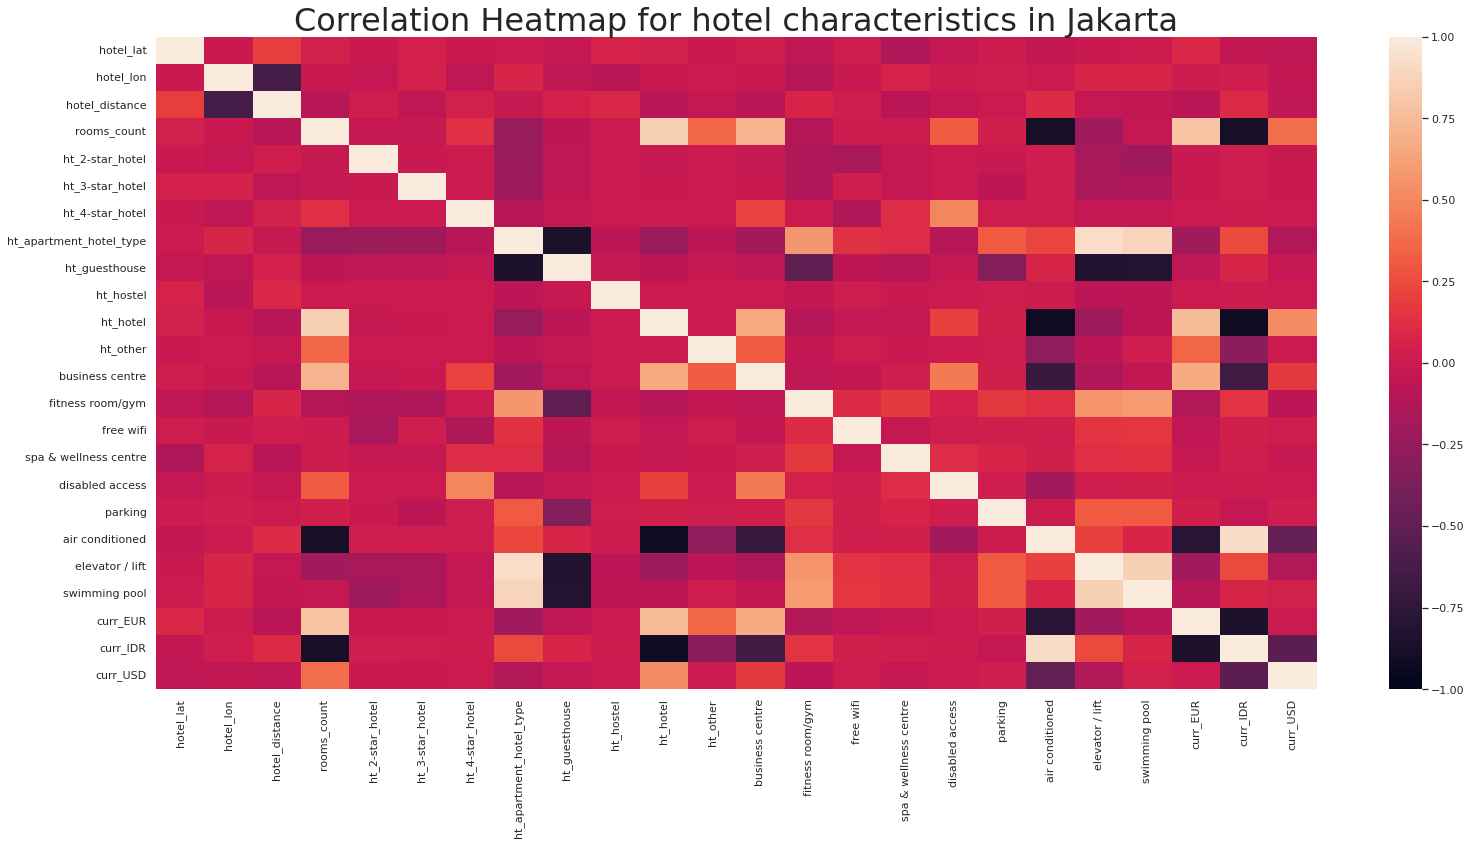

In [401]:

plt.figure(figsize=(26, 12))
plt.rcParams.update({'font.size': 36})
heatmap = sns.heatmap(indonesia.corr(),vmin=-1, vmax=1)
heatmap.set_title("Correlation Heatmap for hotel characteristics in Jakarta", fontdict={"fontsize":32})

Text(0.5, 1.0, 'Correlation Heatmap for hotel characteristics in London')

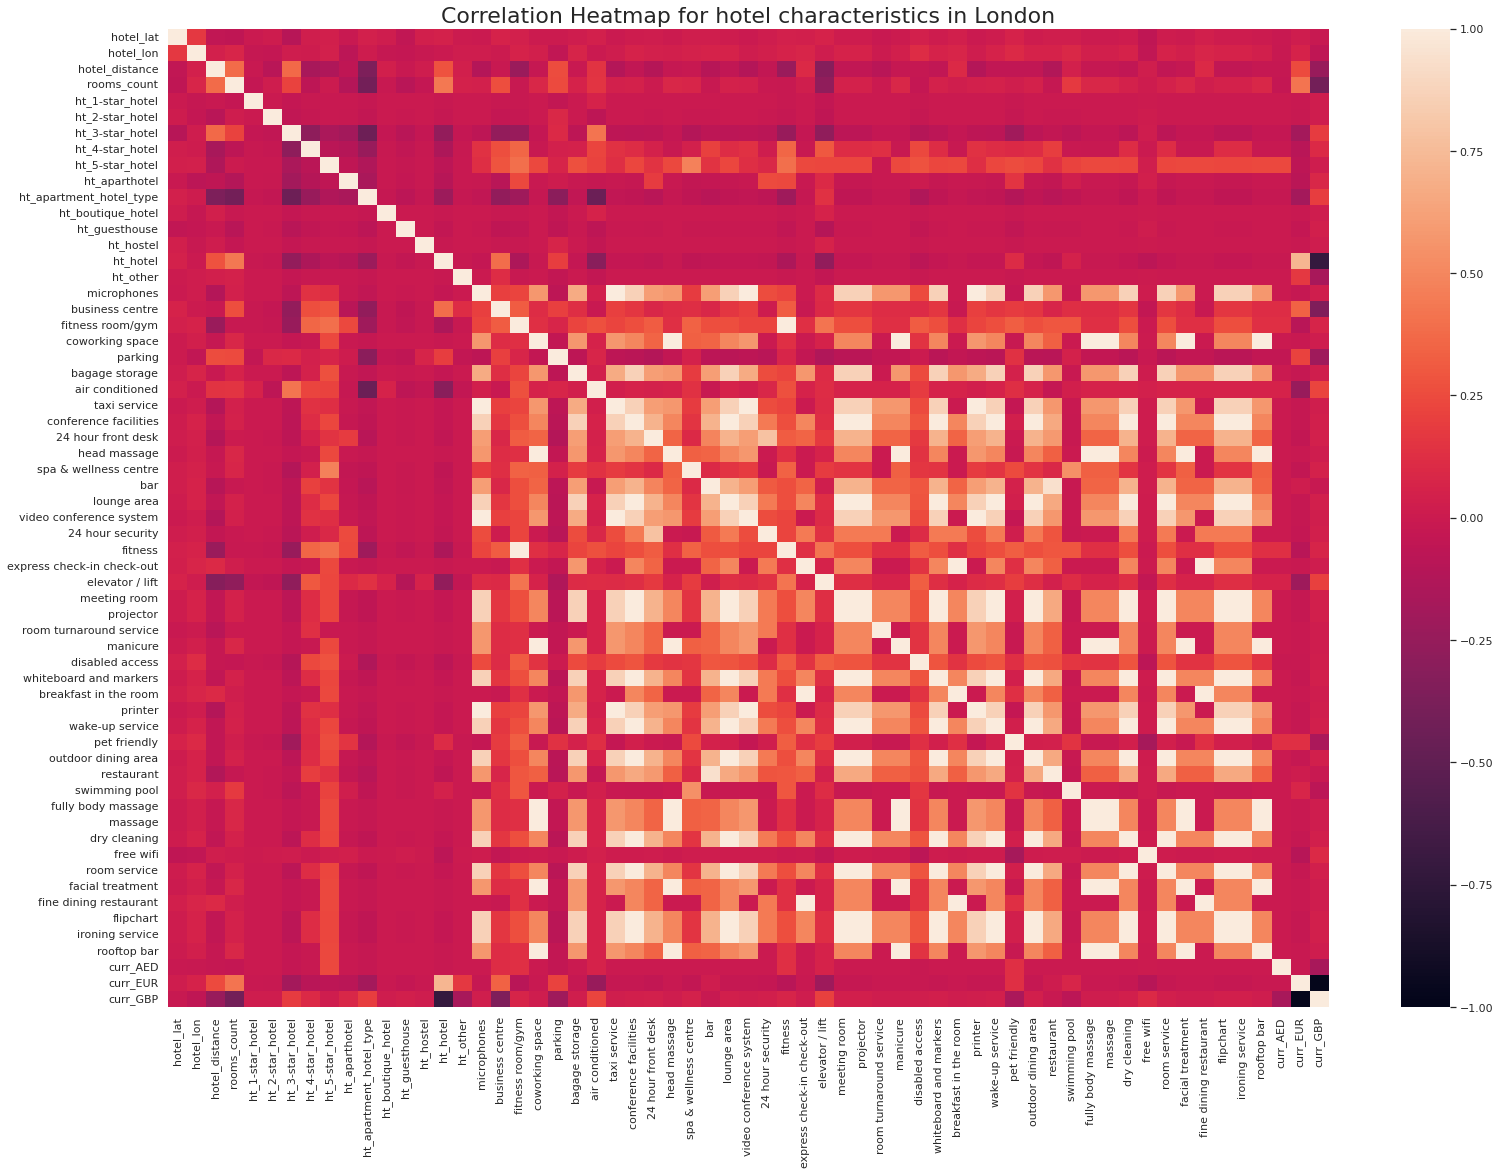

In [402]:

plt.figure(figsize=(26, 18))
plt.rcParams.update({'font.size': 22})
heatmap = sns.heatmap(gb.corr(),vmin=-1, vmax=1)
heatmap.set_title("Correlation Heatmap for hotel characteristics in London", fontdict={"fontsize":22})

### <br> Concusions: 
#### this time I showed the correlaton between amenities separately for each city:
#### - both cities shows different amount of amenities available in given hotels;
#### - most of amenities are highly correlated for London, so they are showing the same segment of characteristics;
#### - the same pairs of amenities showed slightly different level of correlation for Jakarta and London but the trend was similar for both cities<br>


## Data Reduction

#### <br> **calc_vif** - a function that detects strong correlation and returns list of characteristics that should be removed. Here in the function they are listed to ne removed only these characteristics for which the VIF score was higher than 5.
#### **reduce_dimensions_by_pca** -a function that will be reducing dimentions if in the final dataset there will still be a lot of variables. <br>

In [403]:
def calc_vif(df):
    # Multicollinearity detection
    # df - dataFrame
    # col_names - names of columns you would like to calculate the VIF score   
    vif = pd.DataFrame()

    variables = df
    df_vif = add_constant(variables)
    vif["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
    vif["variables"] = df_vif.columns
    vif["VIF"].replace([np.inf, -np.inf], np.nan, inplace=True)
    vifToReduce = vif.loc[(vif["VIF"].isnull())]
    return vifToReduce["variables"].tolist()

def select_variables(df, col_names):
    # returning the 
    if "const" in col_names:       
        const_to_remove = col_names.index("const")
        del col_names[const_to_remove]

    df_selected_variables = df
    df_selected_variables.drop(columns=col_names, inplace=True)

    return df_selected_variables

In [404]:
gbToReduce = calc_vif(gb)
idToReduce = calc_vif(indonesia)

/home/agata/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only

/home/agata/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning:

divide by zero encountered in double_scalars

/home/agata/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning:

divide by zero encountered in double_scalars



#### <br> Removing from the working file variables which are highly correlated <br>

In [405]:
idReduced = select_variables(filesWorkingIDCleaned, idToReduce)
gbReduced = select_variables(filesWorkingGBCleaned, gbToReduce)

#### Creating copy that is not containing Hotel id for the analysis

In [406]:
idReducedAnalysis = idReduced.drop(columns=["hotel_id"])
gbReducedAnalysis = gbReduced.drop(columns=["hotel_id"])

In [407]:
#### ploting correlation heatmap for final hotel characteristics

(648, 13)

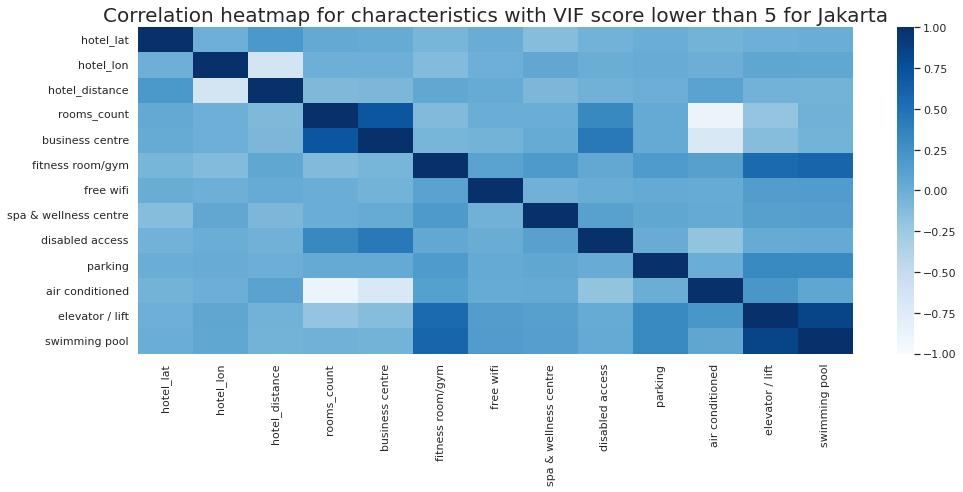

In [408]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(idReducedAnalysis.corr(),vmin=-1, vmax=1, cmap = "Blues")
plt.xticks(rotation=90)
plt.rcParams.update({'font.size': 20})
plt.savefig("heatmap.png", dpi = 300)
plt.title("Correlation heatmap for characteristics with VIF score lower than 5 for Jakarta", fontsize=20)
idReducedAnalysis.shape

(390, 13)

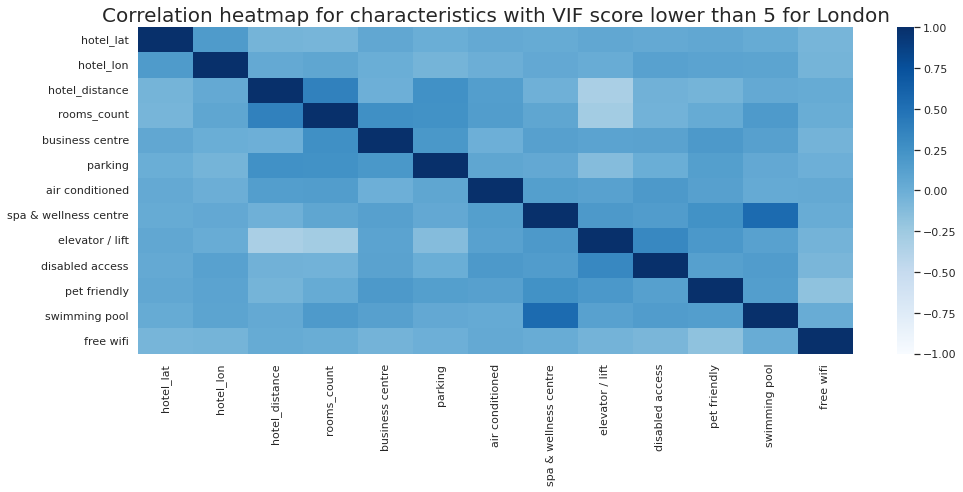

In [409]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(gbReducedAnalysis.corr(),vmin=-1, vmax=1, cmap = "Blues")
plt.xticks(rotation=90)
plt.rcParams.update({'font.size': 20})
plt.savefig("heatmap.png", dpi = 300)
plt.title("Correlation heatmap for characteristics with VIF score lower than 5 for London", fontsize=20)
gbReducedAnalysis.shape

### <br> Conclusions:
#### - this time  function detecting multcolinearity was removing characteristics VIF score higher that 5 what was recomended by documantation, it reduced the dimentions to 9 for Jakarta, 14 for London <br>


## Standarizing data

In [423]:
scaler = StandardScaler()
# standarizing data from Jakarta
indo_std = scaler.fit_transform(idReducedAnalysis)
# standarizing data from London
gb_std = scaler.fit_transform(gbReducedAnalysis)

## First removing Dimentions with PCA for Jakarta

In [424]:
pca_indoesia = PCA(n_components=0.95)
train_pca_indonesia = pca_indoesia.fit_transform(indo_std)
train_pca_indonesia[:1]

array([[ 7.95506727, 10.44159333,  1.18780665,  8.33347921, -2.38154051,
         9.05288163, -3.55850702,  9.13681254,  0.22672492, -0.51728141]])

### Showing how many components is responsible for  95% of variance

In [425]:
pca_indoesia.n_components_

10

### Explained Variance

In [426]:
results = pd.DataFrame(data={"explained_variance_ratio":pca_indoesia.explained_variance_ratio_})
results["cumulative"] = results["explained_variance_ratio"].cumsum()
results["component"] = results.index + 1
results

,explained_variance_ratio,cumulative,component
0,0.225451,0.225451,1
1,0.185026,0.410477,2
2,0.129999,0.540476,3
3,0.088758,0.629234,4
4,0.075131,0.704365,5
5,0.068752,0.773117,6
6,0.063751,0.836868,7
7,0.061787,0.898655,8
8,0.035267,0.933923,9
9,0.024654,0.958577,10


In [427]:
indonesia_reduced = pd.DataFrame(data=train_pca_indonesia.flatten())

## Second removing Dimentions with t-SNE algorythm

In [428]:
tsne = TSNE(n_components=2, verbose=1)
indonesia_tsne = tsne.fit_transform(train_pca_indonesia)

/home/agata/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/agata/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 648 samples in 0.002s...
[t-SNE] Computed neighbors for 648 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 648 / 648
[t-SNE] Mean sigma: 0.358257
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.285671
[t-SNE] KL divergence after 1000 iterations: 0.236611


In [429]:
indonesia_train_tsne_df = pd.DataFrame(data=np.c_[indonesia_tsne], columns = ["tsne_1", "tsne_2"])
indonesia_train_tsne_df

,tsne_1,tsne_2
0,19.572142,10.796942
1,8.644899,0.422069
2,-10.022472,-22.989571
3,17.837936,1.107379
4,2.565225,-23.747639
...,...,...
643,-20.584314,-14.748838
644,-21.520624,-14.318105
645,-21.511532,-14.446935
646,-21.338312,-14.340900


## First removing Dimentions with PCA for London

In [430]:
pca_gb = PCA(n_components=0.95)
train_pca_gb = pca_gb.fit_transform(gb_std)
train_pca_gb[:1]

array([[-0.18661105, -1.39863019, -0.40137586,  0.43415308,  0.80327104,
        -0.28840173, -0.48077823,  0.04361668, -0.88163411, -0.65660846,
         0.42893955,  0.29199019]])

### Showing how many components explains 95% of variance

In [431]:
pca_gb.n_components_

12

### Explained Variance

In [432]:
results = pd.DataFrame(data={"explained_variance_ratio":pca_gb.explained_variance_ratio_})
results["cumulative"] = results["explained_variance_ratio"].cumsum()
results["component"] = results.index + 1
results

,explained_variance_ratio,cumulative,component
0,0.163587,0.163587,1
1,0.147823,0.311409,2
2,0.094783,0.406192,3
3,0.087519,0.493710,4
4,0.086272,0.579982,5
5,0.074101,0.654083,6
6,0.069066,0.723149,7
7,0.061459,0.784608,8
8,0.059436,0.844043,9
9,0.045930,0.889973,10


In [433]:
gb_reduced = pd.DataFrame(data=train_pca_gb.flatten())

## Second removing dimentions with t-SNE algorythm

In [434]:
tsne = TSNE(n_components=2, verbose=1)
gb_tsne = tsne.fit_transform(train_pca_gb)

/home/agata/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/agata/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 390 samples in 0.002s...
[t-SNE] Computed neighbors for 390 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 390 / 390
[t-SNE] Mean sigma: 1.137709
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.458576
[t-SNE] KL divergence after 1000 iterations: 0.377328


In [435]:
gb_train_tsne_df = pd.DataFrame(data=np.c_[gb_tsne], columns = ["tsne_1", "tsne_2"])
gb_train_tsne_df

,tsne_1,tsne_2
0,14.515833,-11.599064
1,22.466930,-10.763362
2,8.412030,-3.164193
3,14.148119,-13.003011
4,8.403682,-3.145921
...,...,...
385,-12.573892,2.294910
386,9.170070,-3.009928
387,6.066321,3.859779
388,22.135147,2.257686


### <br>Conclusions:
#### - After PCA for Jakarta only 8 out of 9 characteristics were responsible for 95% of varianve in data, and how it is visible from cumulative component all of them more or less play the same role in variance
####  - After PCA  for London only 13  out of 14 characteristics were responsible for 95% of varianve in data, and how it is visible from cumulative component all of them more or less play the same role in variance <br>

## DBSCAN Clustering analysis

### <br>There were performed 2 analysis:
#### 1. for Jakarta
#### 2. for London<br>

### 1. Jakarta

#### Calculating the eps and min_samples: this time I reduced dimentions to 2 using t-SNE algoithm that is why as a minimal number of samples was taken 4.  To calculate the average distance between each point and its n_neighbors is generally used the NearestNeighbors 

In [481]:
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(indonesia_tsne)
distances, indices = neighbors_fit.kneighbors(indonesia_tsne)

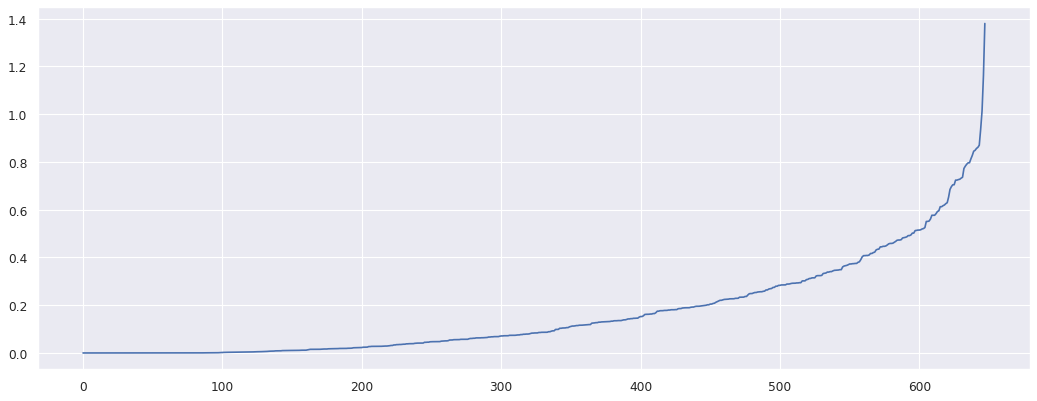

In [482]:
plt.figure(figsize=(16, 6), dpi=80)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [483]:
cluster = DBSCAN(eps=1.1,min_samples=4)
labels = cluster.fit(indonesia_tsne)

In [484]:
np.unique(labels.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37])

In [485]:
n_clusters_ = len(set(labels.labels_)) - (1 if -1 in labels.labels_ else 0)
n_noise_ = list(labels.labels_).count(-1)

In [486]:
dbscan_score = DBCV(indonesia_tsne, labels.labels_, dist_function=euclidean)

In [487]:
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Estimated DBCV: %0.3f" % dbscan_score)

Estimated number of clusters: 38
Estimated number of noise points: 19
Estimated DBCV: 0.294


In [488]:
idReduced["cluster"] = labels.labels_

In [489]:
idReduced

,hotel_id,hotel_lat,hotel_lon,hotel_distance,rooms_count,business centre,fitness room/gym,free wifi,spa & wellness centre,disabled access,parking,air conditioned,elevator / lift,swimming pool,cluster
0,52765,-6.255336,106.810825,6.180000,203,1,1,1,1,1,1,1,1,1,-1
1,506274,-6.175420,106.729023,13.450000,1,0,1,1,0,0,1,1,1,1,0
2,506275,-6.208347,106.818008,3.020000,1,0,0,1,0,0,1,1,1,1,1
3,506278,-6.223455,106.784432,6.840000,1,0,1,1,0,0,1,1,1,1,2
4,506279,-6.162375,106.832172,5.650000,1,0,0,1,0,0,1,1,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,589802,-6.221410,106.815778,3.931276,214,0,0,1,0,0,1,0,0,1,37
644,589803,-6.127151,106.790440,3.931276,300,1,0,1,0,0,1,0,0,0,37
645,589804,-6.264619,106.782179,3.931276,311,1,0,1,0,0,1,0,0,1,37
646,589805,-6.187198,106.821936,3.931276,222,1,0,1,0,0,1,0,0,0,37


In [490]:
indonesia_train_tsne_df["cluster"] = labels.labels_
indonesia_train_tsne_df

,tsne_1,tsne_2,cluster
0,19.572142,10.796942,-1
1,8.644899,0.422069,0
2,-10.022472,-22.989571,1
3,17.837936,1.107379,2
4,2.565225,-23.747639,3
...,...,...,...
643,-20.584314,-14.748838,37
644,-21.520624,-14.318105,37
645,-21.511532,-14.446935,37
646,-21.338312,-14.340900,37


In [491]:
idReduced["cluster"].unique()

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 18, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37])

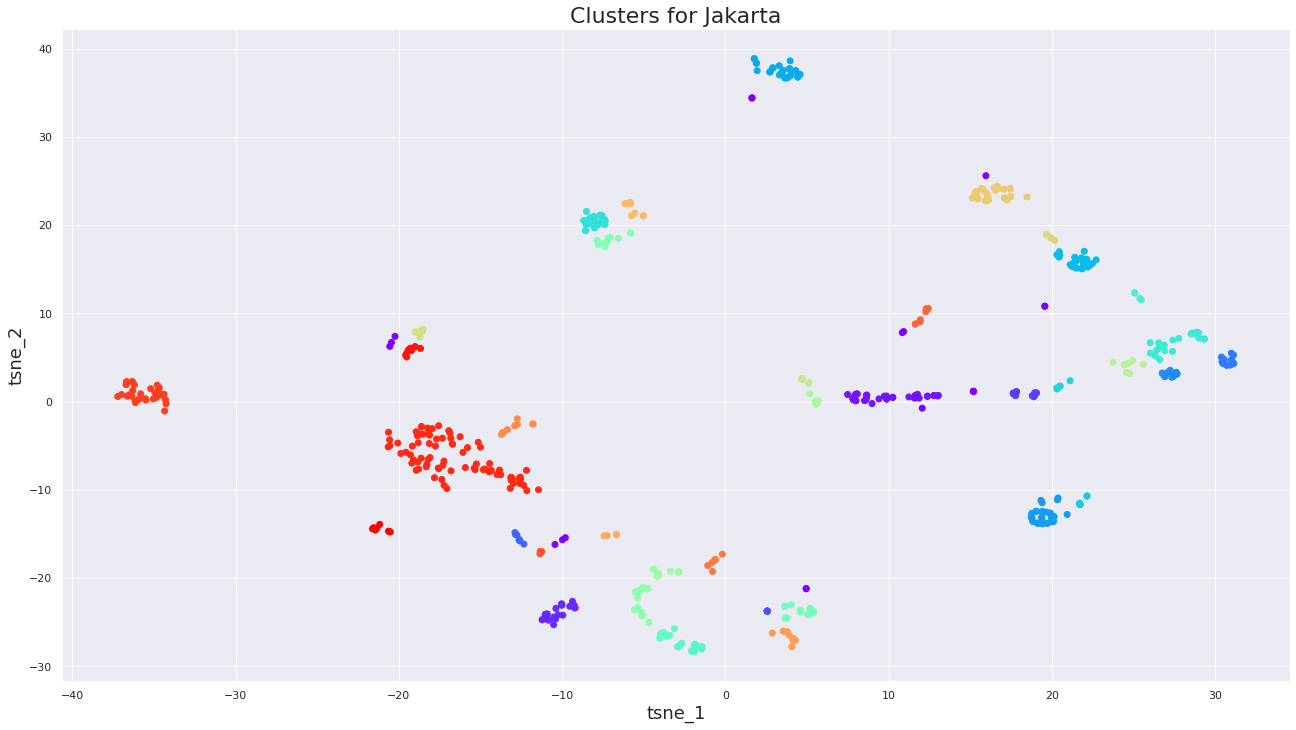

In [492]:
plt.figure(figsize=(22, 12))
axis_font = {'fontname':'Arial', 'size':'18'}
plt.scatter(data=indonesia_train_tsne_df, x="tsne_1", y="tsne_2", c= "cluster", cmap = "rainbow", label = "cluster")
plt.xlabel("tsne_1",**axis_font)
plt.ylabel("tsne_2",**axis_font)
plt.title("Clusters for Jakarta", fontdict={"fontsize":22})
plt.show()

In [493]:
# visualizing the plot in plotly
px.scatter(indonesia_train_tsne_df, x="tsne_1", y="tsne_2", color = "cluster",  template = "plotly_dark", title = "Clusters for Jakarta")

### London

In [508]:
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(gb_tsne)
distances, indices = neighbors_fit.kneighbors(gb_tsne)

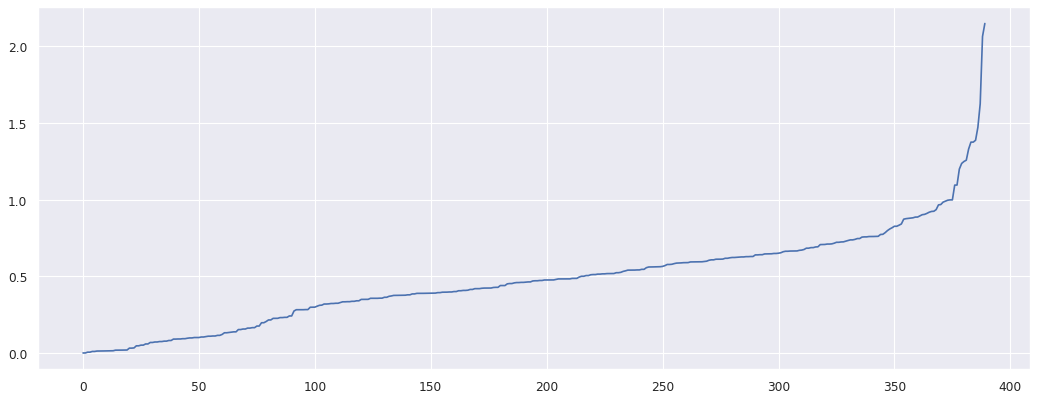

In [509]:
plt.figure(figsize=(16, 6), dpi=80)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [510]:
cluster = DBSCAN(eps=1.7,min_samples=4)
labels = cluster.fit(gb_tsne)

In [511]:
np.unique(labels.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22])

In [512]:
n_clusters_ = len(set(labels.labels_)) - (1 if -1 in labels.labels_ else 0)
n_noise_ = list(labels.labels_).count(-1)

In [513]:
dbscan_score = DBCV(gb_tsne, labels.labels_, dist_function=euclidean)

In [514]:
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Estimated DBCV: %0.3f" % dbscan_score)

Estimated number of clusters: 23
Estimated number of noise points: 19
Estimated DBCV: 0.044


In [515]:
gbReduced["cluster"] = labels.labels_

In [516]:
gbReduced

,hotel_id,hotel_lat,hotel_lon,hotel_distance,rooms_count,business centre,parking,air conditioned,spa & wellness centre,elevator / lift,disabled access,pet friendly,swimming pool,free wifi,cluster
0,5622,51.521259,-0.155856,3.120000,34,0,0,1,0,1,0,0,0,1,0
1,5630,51.512071,-0.185206,4.300000,45,0,0,0,0,1,0,0,0,1,1
2,5640,51.507706,-0.147138,1.670000,106,1,1,0,0,1,0,1,0,1,6
3,5671,51.490098,-0.138130,1.390000,72,0,0,1,0,1,0,0,0,1,0
4,5681,51.496872,-0.167604,2.890000,28,1,1,0,0,1,0,1,0,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,589981,51.508232,0.043758,6.915566,225,0,1,0,0,0,0,0,0,1,20
386,590977,51.516015,-0.118570,1.840000,0,1,1,1,0,1,0,1,0,1,6
387,592390,51.543948,-0.152331,5.200000,1,0,0,0,0,0,0,1,0,1,12
388,592405,51.511208,-0.119345,1.320000,0,0,0,0,0,0,1,0,0,1,15


In [517]:
gb_train_tsne_df["cluster"] = labels.labels_
gb_train_tsne_df

,tsne_1,tsne_2,cluster
0,14.515833,-11.599064,0
1,22.466930,-10.763362,1
2,8.412030,-3.164193,6
3,14.148119,-13.003011,0
4,8.403682,-3.145921,6
...,...,...,...
385,-12.573892,2.294910,20
386,9.170070,-3.009928,6
387,6.066321,3.859779,12
388,22.135147,2.257686,15


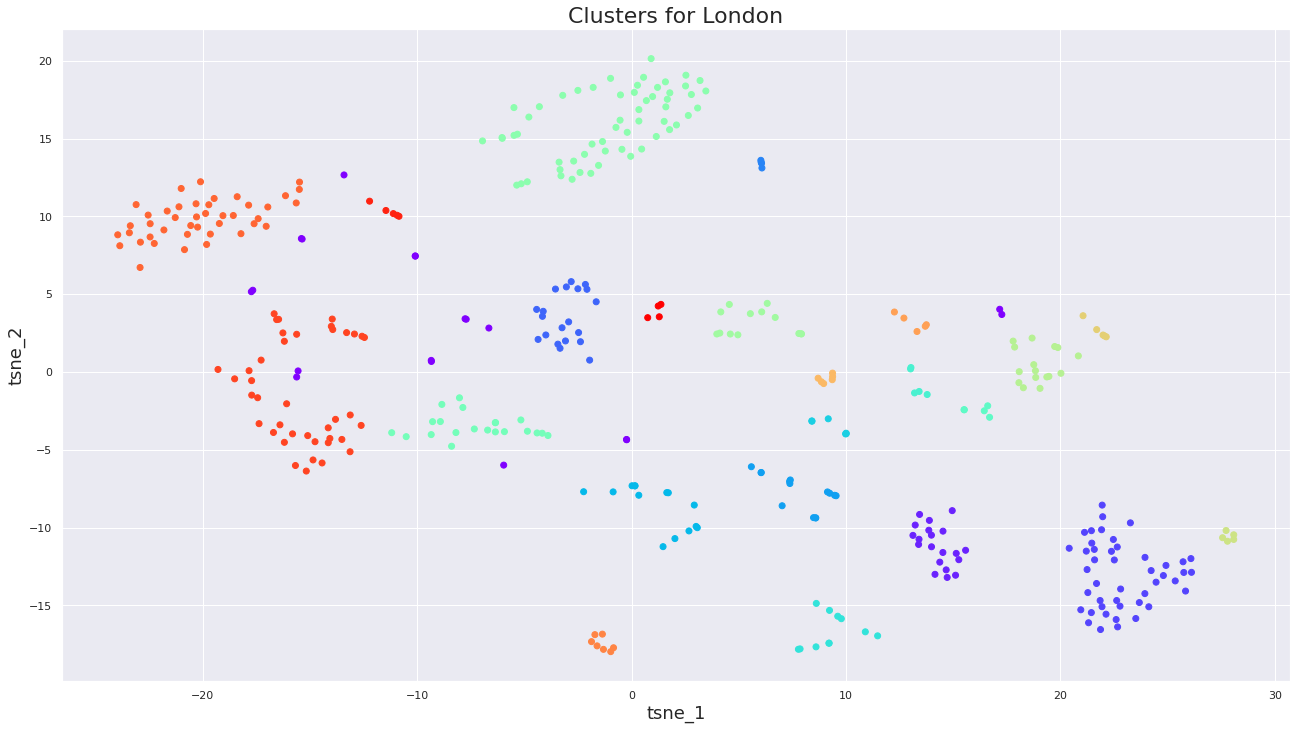

In [518]:
plt.figure(figsize=(22, 12))
axis_font = {'fontname':'Arial', 'size':'18'}
plt.scatter(data=gb_train_tsne_df, x="tsne_1", y="tsne_2", c= "cluster", cmap = "rainbow", label = "cluster")
plt.xlabel("tsne_1",**axis_font)
plt.ylabel("tsne_2",**axis_font)
plt.title("Clusters for London", fontdict={"fontsize":22})
plt.show()

In [519]:
#visualizing data also with plotly express
import plotly.express as px
px.scatter(gb_train_tsne_df, x="tsne_1", y="tsne_2", color = "cluster",  template = "plotly_dark", title = "Clusters for London")

## <br> Concusions:<br>
#### 1. DBSCAN analysis for these 3 types of datasets this time created 40 clusters for Jakarta where different hotel types were 12, 24 for London where different hotel types were 18.
#### 2. Reducing dimentions first usning PCA and second using tSNE gives the opportunity to visualize the two dimentional clusters. The final result witll be known when created clusters will be compared from the business logic.
#### 3. Removing the VIF score above 5 was too strict because it removed hotel_lat and hotel_lon and hotel_city for cumulative analysis.
#### 4. This analysis showed the higest Silhouette Coefficient and the smalles number of noice taking into consideration all analysis from all approches.
#### 5. The next analysis should be performed using HDBSCAN or OPTICS because the do not require eps value and returns the same clusters depending for the same approach<br>

In [520]:
with pd.ExcelWriter("Downloads/dbscanTSNESamples.xlsx") as writer:
    idReduced.to_excel(writer, sheet_name="Jakarta")
    gbReduced.to_excel(writer, sheet_name="London")